# Notebook 1 — Exploratory Data Analysis & Data Preparation

This notebook is the foundation of the TimeGAN project. Its job is threefold: **download** multivariate financial time series data, **explore** it thoroughly to understand the statistical structure the model must learn, and **prepare** the final sliding-window dataset that will feed into training.

We work with six assets — `SPY, GLD, TLT, XLE, MSFT, JPM` — chosen to span distinct asset classes with meaningfully different and regime-dependent correlation structures. The 15-year window (2010–2024) deliberately captures four macroeconomic regimes: the post-GFC bull market, the COVID crash, the 2022 rate-hike cycle, and the 2023 AI-driven rally. This diversity is what makes the dataset an interesting and demanding test for a generative model.

At the end of this notebook we export the processed arrays and the fitted scaler — everything downstream notebooks need.

## 1. Setup & GPU Check

We pin random seeds across NumPy, Python, and TensorFlow to make results reproducible. The GPU check is informational — EDA itself doesn't need a GPU, but confirming the Colab runtime is set up correctly early avoids surprises later.

In [1]:
import os
import json
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# --- Plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#2196F3', '#FF5722', '#4CAF50', '#9C27B0', '#FF9800', '#00BCD4']

# --- GPU check ---
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {gpus[0].name}')
    # Allow memory growth to avoid pre-allocating all VRAM
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print('No GPU detected — running on CPU. Switch to T4 runtime in Colab for training.')

print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')

No GPU detected — running on CPU. Switch to T4 runtime in Colab for training.
TensorFlow version: 2.20.0
NumPy version: 2.1.3


## 2. Data Download

We pull adjusted closing prices from Yahoo Finance via `yfinance`. Adjusted prices account for splits and dividends, which is the correct input for return-based analysis.

**Asset rationale:**
- `SPY` — broad US equity market (S&P 500)
- `GLD` — gold, a traditional safe haven with low/negative equity correlation in crises
- `TLT` — 20+ year US Treasuries, strong negative correlation with equities in pre-2022 regimes
- `XLE` — energy sector, commodity-driven, partially decorrelated from broad market
- `MSFT` — large-cap tech, high SPY correlation (~0.85) but distinct volatility profile
- `JPM` — financials, rate-sensitive, provides an interesting counterpoint to TLT

In [2]:
try:
    import yfinance as yf
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf

TICKERS = ['SPY', 'GLD', 'TLT', 'XLE', 'MSFT', 'JPM']
START_DATE = '2010-01-01'
END_DATE   = '2024-12-31'

print(f'Downloading adjusted close prices for: {TICKERS}')
print(f'Period: {START_DATE} → {END_DATE}')

raw = yf.download(TICKERS, start=START_DATE, end=END_DATE, auto_adjust=True, progress=True)

# Extract the 'Close' level from the multi-level column index
prices = raw['Close'][TICKERS].copy()
prices.index = pd.to_datetime(prices.index)

print(f'\nShape: {prices.shape}')
print(f'Date range: {prices.index[0].date()} → {prices.index[-1].date()}')
prices.head()

Period: 2010-01-01 → 2024-12-31


[*********************100%***********************]  6 of 6 completed


Shape: (3773, 6)
Date range: 2010-01-04 → 2024-12-30


Ticker,SPY,GLD,TLT,XLE,MSFT,JPM
Date,,,,,,
2010-01-04,85.027946,109.800003,56.546909,17.381088,23.130060,28.423927
2010-01-05,85.253036,109.699997,56.912086,17.522957,23.137526,28.974506
2010-01-06,85.313019,111.510002,56.150196,17.732800,22.995527,29.133690
2010-01-07,85.673172,110.820000,56.244671,17.706200,22.756386,29.710800
2010-01-08,85.958275,111.370003,56.219494,17.821453,22.913324,29.637831


## 3. Data Quality Checks

Before any analysis, we verify data integrity: no missing values, correct dtypes, and that the date range aligns with our specification. A single corrupt row could silently bias all downstream statistics.

In [3]:
print('=== DATA QUALITY REPORT ===')
print(f'\nShape:       {prices.shape[0]} trading days × {prices.shape[1]} assets')
print(f'Start date:  {prices.index[0].date()}')
print(f'End date:    {prices.index[-1].date()}')
print(f'\nMissing values per ticker:')
print(prices.isnull().sum())

print(f'\nData types:')
print(prices.dtypes)

print(f'\nBasic price statistics:')
print(prices.describe().round(2))

# Verify there are no NaN-only rows (e.g. market holidays with no data at all)
all_nan_rows = prices[prices.isnull().all(axis=1)]
print(f'\nRows where ALL tickers are NaN: {len(all_nan_rows)}')

# Forward-fill any remaining isolated NaNs (e.g. GLD had a few early gaps)
if prices.isnull().sum().sum() > 0:
    print('Applying forward-fill to isolated NaN values...')
    prices = prices.ffill().dropna()
    print(f'Shape after cleaning: {prices.shape}')

=== DATA QUALITY REPORT ===

Shape:       3773 trading days × 6 assets
Start date:  2010-01-04
End date:    2024-12-30

Missing values per ticker:
Ticker
SPY     0
GLD     0
TLT     0
XLE     0
MSFT    0
JPM     0
dtype: int64

Data types:
Ticker
SPY     float64
GLD     float64
TLT     float64
XLE     float64
MSFT    float64
JPM     float64
dtype: object

Basic price statistics:
Ticker      SPY      GLD      TLT      XLE     MSFT      JPM
count   3773.00  3773.00  3773.00  3773.00  3773.00  3773.00
mean     245.72   146.60    94.08    25.71   128.81    79.79
std      131.42    31.43    19.50     7.62   124.25    49.75
min       77.36   100.50    55.65     9.31    17.35    19.31
25%      137.58   120.64    82.32    21.41    28.62    38.89
50%      212.15   138.22    92.64    23.70    64.51    71.95
75%      360.13   168.44   101.18    27.56   226.96   112.56
max      598.74   257.50   145.38    46.67   462.38   244.00

Rows where ALL tickers are NaN: 0


## 4. Price Visualisation

We rebase all prices to 100 at inception so that cumulative performance is directly comparable across assets with very different price levels. This is a standard convention for multi-asset charts — without rebasing, MSFT's absolute price would visually dominate everything else.

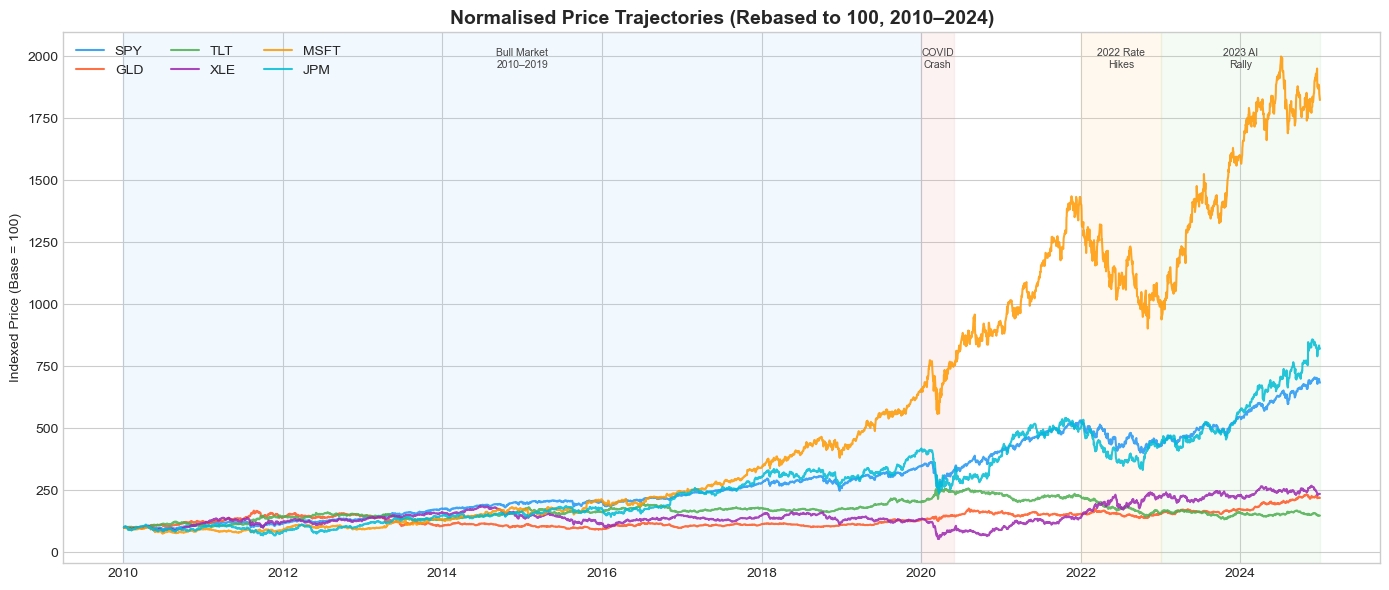

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

# Rebase each series to 100 at its first observation
rebased = prices.div(prices.iloc[0]) * 100

for ticker, color in zip(TICKERS, COLORS):
    ax.plot(rebased.index, rebased[ticker], label=ticker, color=color, linewidth=1.5, alpha=0.85)

ax.set_title('Normalised Price Trajectories (Rebased to 100, 2010–2024)', fontsize=14, fontweight='bold')
ax.set_ylabel('Indexed Price (Base = 100)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend(loc='upper left', ncol=3, framealpha=0.9)

# Annotate the four regimes with vertical bands — purely visual, no data dependency
regime_spans = [
    ('2010-01-01', '2020-01-01', '#90CAF9', 'Bull Market\n2010–2019'),
    ('2020-01-01', '2020-06-01', '#EF9A9A', 'COVID\nCrash'),
    ('2022-01-01', '2023-01-01', '#FFCC80', '2022 Rate\nHikes'),
    ('2023-01-01', '2024-12-31', '#A5D6A7', '2023 AI\nRally'),
]
for start, end, color, label in regime_spans:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.12, color=color)
    mid = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.97, label, ha='center', va='top', fontsize=7.5, color='#444')

plt.tight_layout()
import os
if not os.path.exists('data'):
    os.makedirs('data')
plt.savefig('data/price_trajectories.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Returns Analysis

We work in log-return space throughout. Log returns are additive over time (convenient for multi-period aggregation) and better-behaved statistically than simple returns for modelling.

We look at three things:
1. **Distributions** — histogram + KDE to see the shape (fat tails expected)
2. **QQ-plot** — formal visual test for normality; financial returns famously deviate from the Gaussian assumption
3. **Rolling volatility** — 30-day rolling standard deviation reveals volatility clustering (ARCH effects), which TimeGAN must reproduce to be useful

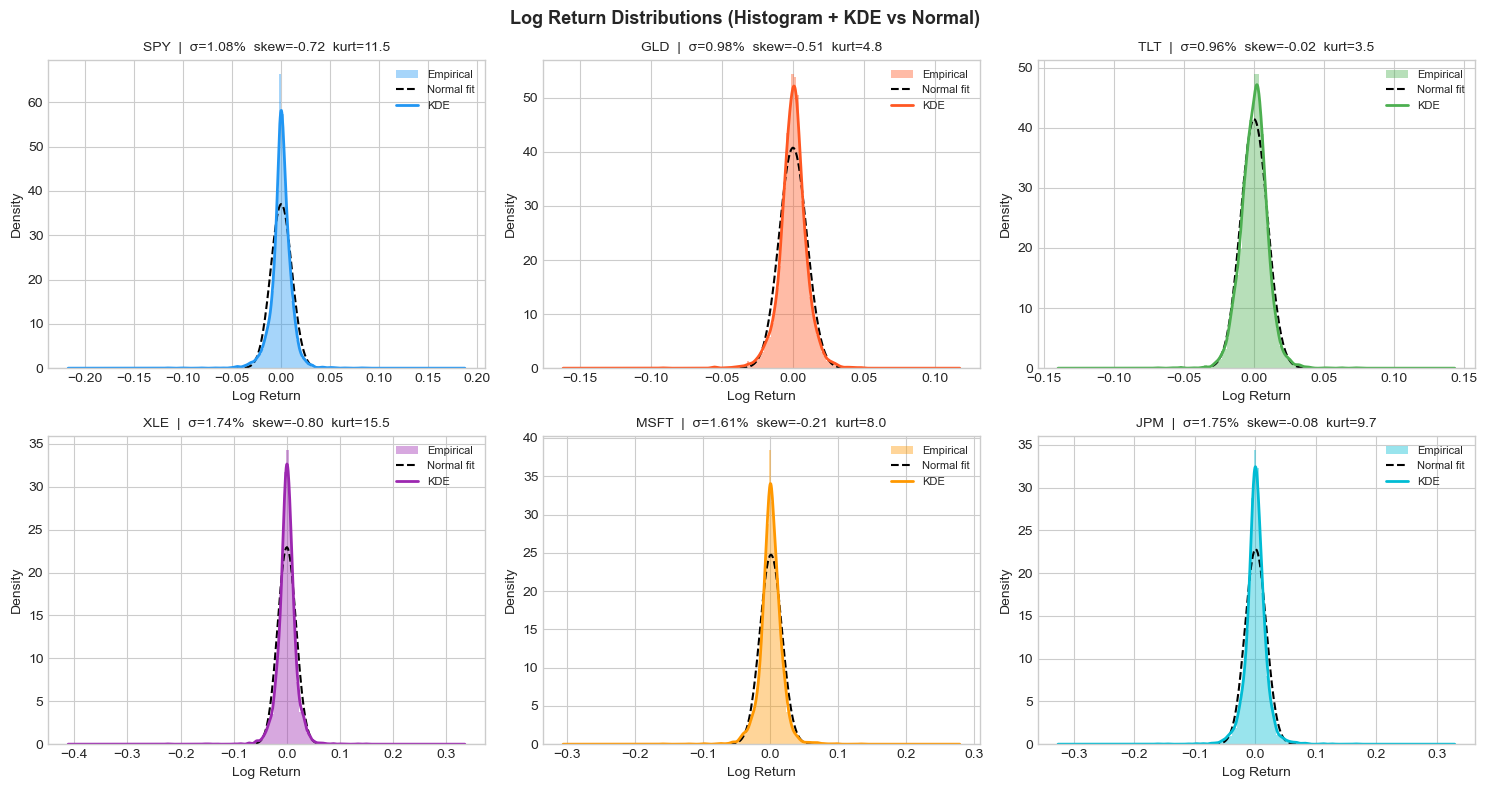

In [7]:
log_returns = np.log(prices / prices.shift(1)).dropna()

# --- Distribution plots: histogram + KDE for each ticker ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (ticker, color) in enumerate(zip(TICKERS, COLORS)):
    r = log_returns[ticker].dropna()
    axes[i].hist(r, bins=80, density=True, alpha=0.4, color=color, label='Empirical')
    
    # Overlay fitted normal for comparison — the gap between the two shows fat tails
    xrange = np.linspace(r.min(), r.max(), 200)
    axes[i].plot(xrange, stats.norm.pdf(xrange, r.mean(), r.std()), 
                 'k--', linewidth=1.5, label='Normal fit')
    r.plot.kde(ax=axes[i], color=color, linewidth=2, label='KDE')
    
    axes[i].set_title(f'{ticker}  |  σ={r.std()*100:.2f}%  skew={r.skew():.2f}  kurt={r.kurtosis():.1f}', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].set_xlabel('Log Return')

fig.suptitle('Log Return Distributions (Histogram + KDE vs Normal)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('data/return_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

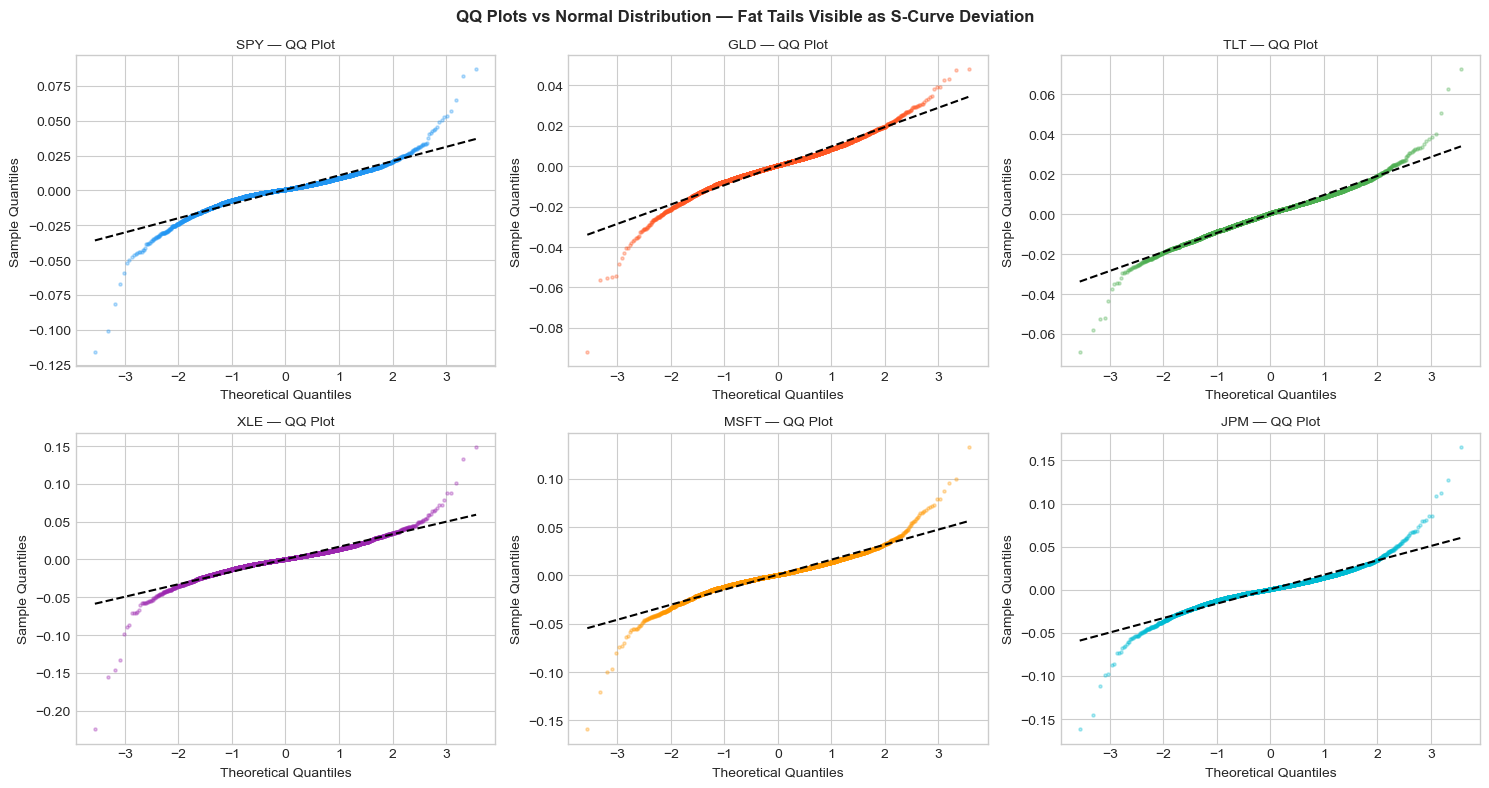

In [8]:
# --- QQ-plots: deviations from the diagonal signal non-normality ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (ticker, color) in enumerate(zip(TICKERS, COLORS)):
    r = log_returns[ticker].dropna()
    (osm, osr), (slope, intercept, _) = stats.probplot(r, dist='norm')
    axes[i].scatter(osm, osr, alpha=0.3, s=5, color=color)
    axes[i].plot(osm, slope * np.array(osm) + intercept, 'k--', linewidth=1.5)
    axes[i].set_title(f'{ticker} — QQ Plot', fontsize=10)
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')

fig.suptitle('QQ Plots vs Normal Distribution — Fat Tails Visible as S-Curve Deviation', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('data/qq_plots.png', dpi=150, bbox_inches='tight')
plt.show()

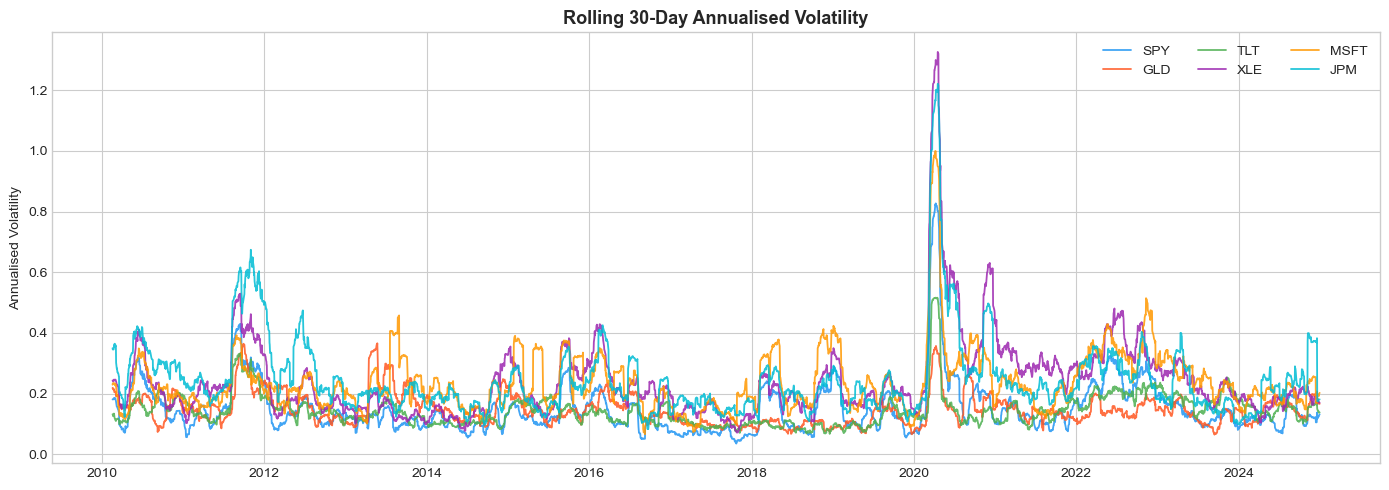

In [9]:
# --- Rolling 30-day volatility ---
rolling_vol = log_returns.rolling(30).std() * np.sqrt(252)  # Annualised

fig, ax = plt.subplots(figsize=(14, 5))
for ticker, color in zip(TICKERS, COLORS):
    ax.plot(rolling_vol.index, rolling_vol[ticker], label=ticker, color=color, linewidth=1.3, alpha=0.85)

ax.set_title('Rolling 30-Day Annualised Volatility', fontsize=13, fontweight='bold')
ax.set_ylabel('Annualised Volatility')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend(loc='upper right', ncol=3)
plt.tight_layout()
plt.savefig('data/rolling_volatility.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlation Analysis

Two views on correlation:

1. **Static heatmap** — the unconditional correlation matrix across the full 15-year period. This is what the model must reproduce on average.
2. **Rolling 90-day correlations vs SPY** — this reveals how correlations shift across regimes. The well-known SPY/TLT flight-to-quality relationship (negative in crises, near-zero post-2022) is a canonical example of regime-dependent structure — and a meaningful test for the synthetic data.

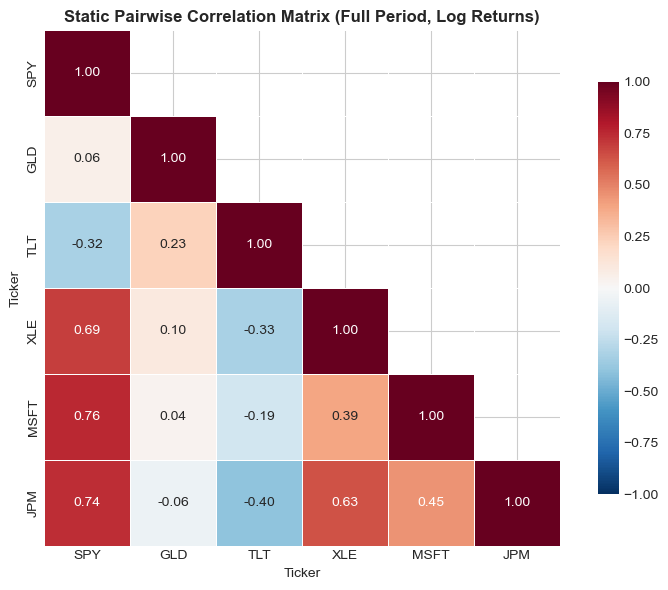


Correlation matrix:
Ticker    SPY    GLD    TLT    XLE   MSFT    JPM
Ticker                                          
SPY     1.000  0.055 -0.321  0.688  0.756  0.739
GLD     0.055  1.000  0.230  0.096  0.035 -0.061
TLT    -0.321  0.230  1.000 -0.325 -0.192 -0.400
XLE     0.688  0.096 -0.325  1.000  0.391  0.635
MSFT    0.756  0.035 -0.192  0.391  1.000  0.451
JPM     0.739 -0.061 -0.400  0.635  0.451  1.000


In [10]:
corr_matrix = log_returns.corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr_matrix), k=1)  # Only show lower triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            vmin=-1, vmax=1, center=0, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8}, ax=ax)
ax.set_title('Static Pairwise Correlation Matrix (Full Period, Log Returns)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('data/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nCorrelation matrix:')
print(corr_matrix.round(3))

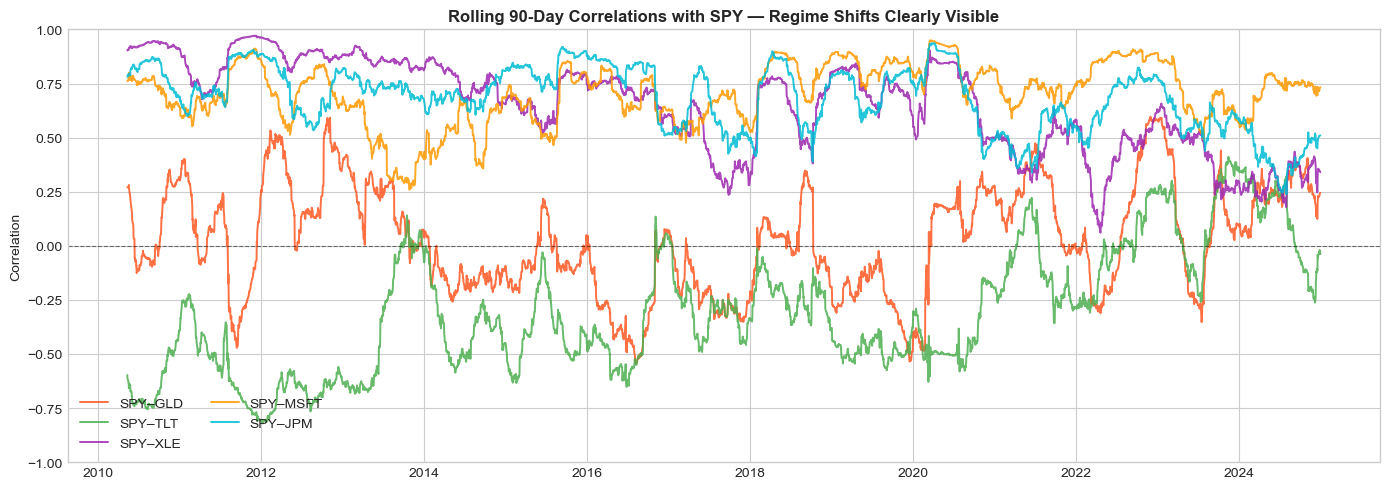

In [11]:
# --- Rolling 90-day pairwise correlation between SPY and each other asset ---
# 90 days balances statistical stability with responsiveness to regime shifts
fig, ax = plt.subplots(figsize=(14, 5))

other_tickers = [t for t in TICKERS if t != 'SPY']
for ticker, color in zip(other_tickers, COLORS[1:]):
    roll_corr = log_returns['SPY'].rolling(90).corr(log_returns[ticker])
    ax.plot(roll_corr.index, roll_corr, label=f'SPY–{ticker}', color=color, linewidth=1.4, alpha=0.85)

ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_title('Rolling 90-Day Correlations with SPY — Regime Shifts Clearly Visible', fontsize=12, fontweight='bold')
ax.set_ylabel('Correlation')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend(loc='lower left', ncol=2)
ax.set_ylim(-1, 1)
plt.tight_layout()
plt.savefig('data/rolling_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Regime Identification

We annotate four distinct macroeconomic regimes on the SPY return series. This is qualitative — the regimes serve as interpretive context for the correlation analysis and for evaluating whether the synthetic data captures structural diversity. TimeGAN is trained on all four regimes simultaneously; we don't condition on regime labels.

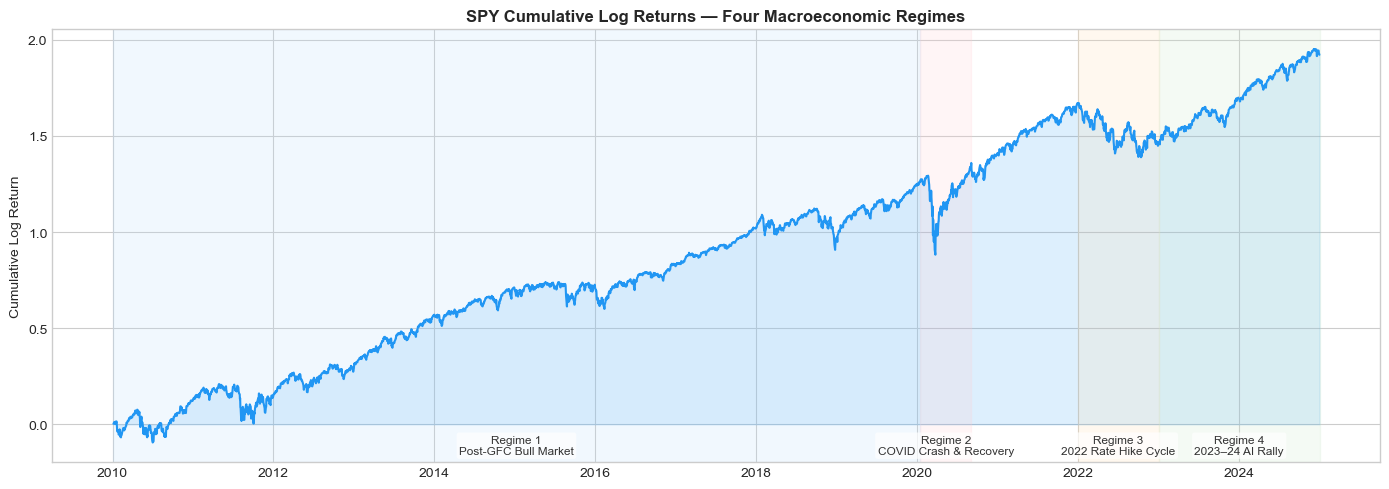

In [12]:
fig, ax = plt.subplots(figsize=(14, 5))

# Plot cumulative SPY log return as the regime backdrop
spy_cumret = log_returns['SPY'].cumsum()
ax.plot(spy_cumret.index, spy_cumret, color=COLORS[0], linewidth=1.5, label='SPY Cumulative Log Return')
ax.fill_between(spy_cumret.index, spy_cumret, alpha=0.15, color=COLORS[0])

# Regime annotations: dates are approximate but defensible given the macro events
regimes = [
    ('2010-01-01', '2020-01-15', '#BBDEFB', 'Regime 1\nPost-GFC Bull Market'),
    ('2020-01-15', '2020-09-01', '#FFCDD2', 'Regime 2\nCOVID Crash & Recovery'),
    ('2022-01-01', '2022-12-31', '#FFE0B2', 'Regime 3\n2022 Rate Hike Cycle'),
    ('2023-01-01', '2024-12-31', '#C8E6C9', 'Regime 4\n2023–24 AI Rally'),
]
for start, end, color, label in regimes:
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.2, color=color)
    mid = pd.Timestamp(start) + (pd.Timestamp(end) - pd.Timestamp(start)) / 2
    ax.text(mid, ax.get_ylim()[0] * 0.85 if ax.get_ylim()[0] < 0 else ax.get_ylim()[1] * 0.1,
            label, ha='center', va='bottom', fontsize=8.5, color='#333',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_title('SPY Cumulative Log Returns — Four Macroeconomic Regimes', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Log Return')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.savefig('data/regime_identification.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Data Preparation

Three steps to go from raw prices to a training-ready tensor:

1. **MinMax scaling to [0, 1]**: Required by TimeGAN's architecture — the Embedder and Generator work with normalised inputs. We fit the scaler on all data (no train/val split here; the GAN's generative objective doesn't require held-out validation in the supervised-learning sense, and splitting would reduce the number of windows available for training).

2. **Sliding windows of length 24**: Each window captures approximately one calendar month of trading data (5 days × 4–5 weeks ≈ 21–23 trading days, rounded to 24 for a clean number). A 1-day stride maximises the number of training examples while keeping temporal diversity.

3. **Export**: Arrays and the fitted scaler are saved to disk so that the training notebook can load them without re-running EDA.

In [13]:
SEQ_LEN = 24   # ~1 calendar month of trading days
N_SEQ   = len(TICKERS)  # 6 features

# --- Scale to [0, 1] ---
# We fit on the full dataset. The scaler is saved for inverse-transforming synthetic data later.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices.values)  # shape: (T, 6)

print(f'Scaled data shape:    {scaled_data.shape}')
print(f'Value range after scaling: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]')

# --- Sliding windows with stride=1 ---
def create_sliding_windows(data, seq_len):
    """Extract non-overlapping-indexed subsequences from a 2D array.
    
    Stride=1 maximises the number of training examples; each window overlaps
    its neighbours by (seq_len - 1) steps. This is standard for sequence models
    on financial data where the dataset size is already limited.
    """
    n_windows = len(data) - seq_len + 1
    windows = np.array([data[i : i + seq_len] for i in range(n_windows)])
    return windows

windows = create_sliding_windows(scaled_data, SEQ_LEN)  # shape: (n_windows, 24, 6)

print(f'\nWindows array shape:  {windows.shape}  →  (n_windows, seq_len, n_features)')
print(f'Number of windows:    {windows.shape[0]}')
print(f'Window length:        {SEQ_LEN} days')
print(f'Features:             {N_SEQ} assets')

Scaled data shape:    (3773, 6)
Value range after scaling: [0.0000, 1.0000]

Windows array shape:  (3750, 24, 6)  →  (n_windows, seq_len, n_features)
Number of windows:    3750
Window length:        24 days
Features:             6 assets


In [14]:
os.makedirs('data', exist_ok=True)

# --- Save artefacts ---
np.save('data/scaled_data.npy', scaled_data)
np.save('data/windows.npy', windows)
np.save('data/prices_raw.npy', prices.values)
np.save('data/log_returns.npy', log_returns.values)

with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('data/tickers.json', 'w') as f:
    json.dump(TICKERS, f)

# Save date index as strings for easy reconstruction in other notebooks
with open('data/dates.json', 'w') as f:
    json.dump(prices.index.strftime('%Y-%m-%d').tolist(), f)

# Save the log-returns column labels alongside the arrays for downstream reference
prices.to_csv('data/prices.csv')
log_returns.to_csv('data/log_returns.csv')

print('Saved to data/:')
for fname in ['scaled_data.npy', 'windows.npy', 'prices_raw.npy',
              'log_returns.npy', 'scaler.pkl', 'tickers.json', 'dates.json',
              'prices.csv', 'log_returns.csv']:
    size = os.path.getsize(f'data/{fname}')
    print(f'  {fname:<30}  ({size/1024:.1f} KB)')

Saved to data/:
  scaled_data.npy                 (177.0 KB)
  windows.npy                     (4218.9 KB)
  prices_raw.npy                  (177.0 KB)
  log_returns.npy                 (176.9 KB)
  scaler.pkl                      (0.7 KB)
  tickers.json                    (0.0 KB)
  dates.json                      (51.6 KB)
  prices.csv                      (448.2 KB)
  log_returns.csv                 (519.7 KB)


## 9. Final Summary

Everything downstream notebooks need is now on disk. Here's a concise summary of the dataset and the key parameter choices made in this notebook.

In [15]:
print('=' * 55)
print('  DATASET SUMMARY')
print('=' * 55)
print(f'  Assets:              {", ".join(TICKERS)}')
print(f'  Period:              {START_DATE} → {END_DATE}')
print(f'  Trading days:        {len(prices)}')
print(f'  Scaled data shape:   {scaled_data.shape}  (T × n_features)')
print(f'  Windows shape:       {windows.shape}  (n_windows × seq_len × n_features)')
print()
print('  PARAMETERS')
print('-' * 55)
params = {
    'seq_len':          SEQ_LEN,
    'n_seq (features)': N_SEQ,
    'n_windows':        windows.shape[0],
    'stride':           1,
    'scaler':           'MinMaxScaler [0, 1]',
    'seed':             SEED,
}
for k, v in params.items():
    print(f'  {k:<22} {v}')
print('=' * 55)

print('\nReturn statistics (full period):')
stats_df = pd.DataFrame({
    'Mean (ann.)':  (log_returns.mean() * 252).round(4),
    'Vol (ann.)':   (log_returns.std() * np.sqrt(252)).round(4),
    'Skewness':     log_returns.skew().round(3),
    'Excess Kurt.': log_returns.kurtosis().round(3),
})
print(stats_df.to_string())

  DATASET SUMMARY
  Assets:              SPY, GLD, TLT, XLE, MSFT, JPM
  Period:              2010-01-01 → 2024-12-31
  Trading days:        3773
  Scaled data shape:   (3773, 6)  (T × n_features)
  Windows shape:       (3750, 24, 6)  (n_windows × seq_len × n_features)

  PARAMETERS
-------------------------------------------------------
  seq_len                24
  n_seq (features)       6
  n_windows              3750
  stride                 1
  scaler                 MinMaxScaler [0, 1]
  seed                   42

Return statistics (full period):
        Mean (ann.)  Vol (ann.)  Skewness  Excess Kurt.
Ticker                                                 
SPY          0.1284      0.1710    -0.722        11.542
GLD          0.0524      0.1553    -0.508         4.819
TLT          0.0262      0.1528    -0.020         3.452
XLE          0.0572      0.2758    -0.797        15.504
MSFT         0.1940      0.2558    -0.210         8.024
JPM          0.1406      0.2774    -0.076        